In [18]:
;cd "/home/bachir/Dropbox/AAA_Bachir/Learning_with_side_information/Code/"


/home/bachir/Dropbox/AAA_Bachir/Learning_with_side_information/Code


In [19]:
]activate learning_ds

In [20]:
include("plotting_utilities.jl")
include("ode_helper.jl")
using SumOfSquares
using DynamicPolynomials
using MosekTools
using Plots

┌ Info: Recompiling stale cache file /home/bachir/.julia/compiled/v1.1/DifferentialEquations/UQdwS.ji for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1184
┌ Warning: Package DiffEqFinancial does not have Markdown in its dependencies:
│ - If you have DiffEqFinancial checked out for development and have
│   added Markdown as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with DiffEqFinancial
└ Loading Markdown into DiffEqFinancial from project dependency, future warnings for DiffEqFinancial are suppressed.
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
│   exception = ErrorException("Required dependency DiffEqFinancial [5a0ffddc-d203-54b0-88ba-2c03c0fc2e67] failed to load from a cache file.")
└ @ Base loading.jl:969
┌ Info: Recompiling stale cache file 

Loaded diff equations


In [100]:
m = [1., 1.]
G = 1.

function true_vf(u, p , t)
    # u = [ẋ1, ẋ2, x1, x2]
    ẋ1 = u[1:2]
    ẋ2 = u[3:4]
    x1 = u[5:6]
    x2 = u[7:8]
    n = x1 - x2
    r = sqrt(sum(n.^2))
    vf_u = vcat(-m[2] *G/r^2*n, m[1] *G/r^2*n, ẋ1, ẋ2)
    return vf_u
end

true_vf (generic function with 1 method)

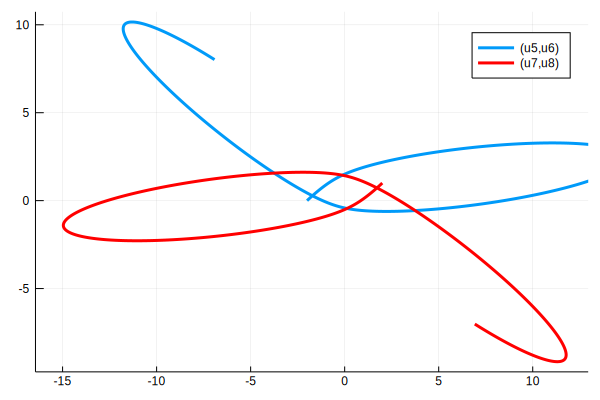

In [157]:
u₀ = [1, 1,
      -1, -1,
      -2, 0,
      2, 1
] .* 1.0

T = 100
#num_samples = 2
prob = ODEProblem(true_vf, u₀, (0., T))
sol = DifferentialEquations.solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
Plots.plot(sol, vars=(5, 6))
Plots.plot!(sol, vars=(7, 8), color=:red)

In [158]:
num_samples = 100
dt = T/num_samples

u_t = []
for i=0:num_samples-1
    u_t = [u_t..., sol(i * dt)]
end
u_t

100-element Array{Array{Float64,1},1}:
 [1.0, 1.0, -1.0, -1.0, -2.0, 0.0, 2.0, 1.0]                                        
 [1.34243, 0.966151, -1.34243, -0.966151, -0.847871, 1.00716, 0.847871, -0.00716263]
 [1.451, 0.533267, -1.451, -0.533267, 0.60746, 1.75702, -0.60746, -0.757023]        
 [1.28881, 0.332917, -1.28881, -0.332917, 1.97589, 2.17427, -1.97589, -1.17427]     
 [1.15948, 0.240334, -1.15948, -0.240334, 3.19724, 2.4564, -3.19724, -1.4564]       
 [1.05704, 0.183572, -1.05704, -0.183572, 4.30375, 2.66646, -4.30375, -1.66646]     
 [0.971696, 0.143519, -0.971696, -0.143519, 5.31698, 2.82901, -5.31698, -1.82901]   
 [0.897869, 0.112897, -0.897869, -0.112897, 6.25096, 2.95661, -6.25096, -1.95661]   
 [0.832277, 0.0882514, -0.832277, -0.0882514, 7.11545, 3.05678, -7.11545, -2.05678] 
 [0.772846, 0.0677026, -0.772846, -0.0677026, 7.91756, 3.13447, -7.91756, -2.13447] 
 [0.718183, 0.0501213, -0.718183, -0.0501213, 8.66273, 3.19317, -8.66273, -2.19317] 
 [0.667308, 0.0347819, -0.

# Learn a polynomial vector field

In [159]:
@polyvar v[1:8]
# u
deg = 2
mons = monomials(v, 2)
model = SOSModel(with_optimizer(Mosek.Optimizer))
@variable model c[1:4, 1:size(mons, 1)]
@variable model γ

f = vcat(c * mons, v[1:4])
                
eval_f(x) = map(fi -> fi.a[1], subs(f, v=>x))
eval_true_vf(x) = true_vf(x, 0, 0)

error_term = (hcat(eval_true_vf.(u_t)...) .- hcat(eval_f.(u_t)...))
error_term = [error_term...]
@constraint model [γ, error_term...] in SecondOrderCone()
@objective model Min γ
optimize!(model)
@show value(γ) / size(error_term, 1)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 801             
  Cones                  : 1               
  Scalar variables       : 946             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 4               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimizat

0.000656667193456332

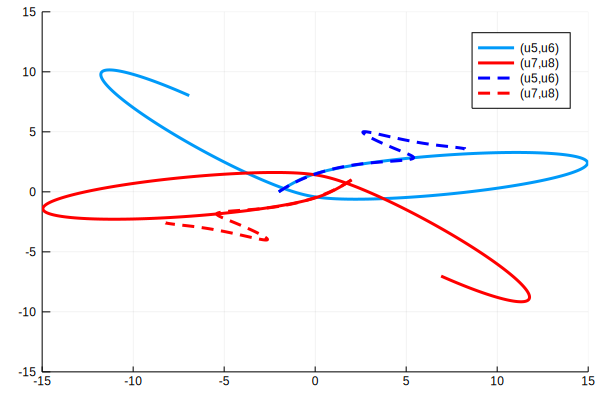

In [166]:
T_eval = T
value_f = value.(f)
eval_value_f(x) = map(fi -> fi.a[1], subs(value_f, v=>x))

learned_vf = (u, p, t) -> eval_value_f(u)
prob = ODEProblem(learned_vf, u₀, (0., T_eval))
learn_sol = DifferentialEquations.solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)

Plots.plot(sol, vars=(5, 6))
Plots.plot!(sol, vars=(7, 8), color=:red)

Plots.plot!(learn_sol, vars=(5, 6), color=:blue, ls=:dash)
Plots.plot!(learn_sol, vars=(7, 8), color=:red, ls=:dash)

Plots.xlims!(-15, 15)
Plots.ylims!(-15, 15)